# 📰 News Article Similarity Analysis using NLP 🧠📊

## 🎯 Objective
This notebook explores text similarity among news articles using NLP techniques. We will:

✅ Convert text into numerical vectors using pre-trained **GloVe embeddings**.  
✅ Reduce dimensionality for visualization using **PCA**.  
✅ Apply **K-Means clustering** to group similar news articles.  

---

## 🔍 Why GloVe?
GloVe (**Global Vectors for Word Representation**) provides **dense vector embeddings** trained on a large corpus, allowing us to capture the **semantic meaning** of words efficiently. 🏆✨  

Using GloVe, we can **transform text into meaningful numerical representations** for further processing and clustering. 🚀📖


In [52]:
# 📥 Import necessary libraries
# ⬇️ Download stopwords for text cleaning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import re

nltk.download('stopwords')
nltk.download('punkt_tab')
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import urllib.request
import os
import zipfile

from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from wordcloud import WordCloud
from collections import Counter

## 📊 Data Overview
The dataset consists of news articles with the following columns:

📰 **title**: The headline of the news article.  
📄 **content**: The full text of the article.  

🎯 Our goal is to **analyze the similarity between articles** and **group them into clusters** for better understanding. 🔍🤖  


In [2]:
# Download the dataset
!wget https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv

# Load the dataset into a pandas DataFrame
df = pd.read_csv("news_articles.csv")

--2025-03-27 08:06:46--  https://raw.githubusercontent.com/mage-ai/datasets/refs/heads/master/news_articles.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18236066 (17M) [text/plain]
Saving to: ‘news_articles.csv’

news_articles.csv   100%[===================>]  17.39M  --.-KB/s    in 0.1s    

2025-03-27 08:06:48 (134 MB/s) - ‘news_articles.csv’ saved [18236066/18236066]



In [10]:
# Display basic dataset information
print("📊 Dataset Overview:")
print(f"Shape: {df.shape} (rows, columns)")
print("\n🔍 First 5 rows:")
display(df.head())

print("\n📝 Column-wise info (non-null counts & data types):")
print(df.info())

print("\n🧹 Missing values per column:")
print(df.isnull().sum())

print("\n📰 Sample article content (first article):")
print("\nTopic:", df['topic'].iloc[0])
print("\nHeadline preview:", df['headline'].iloc[0])
print("\nDescription preview:", df['description'].iloc[0])


📊 Dataset Overview:
Shape: (55335, 6) (rows, columns)

🔍 First 5 rows:


topic                                           headline  \
0  entertainment  Will Smith Joins Diplo And Nicky Jam For The 2...   
1  entertainment    Hugh Grant Marries For The First Time At Age 57   
2  entertainment  Morgan Freeman 'Devastated' That Sexual Harass...   
3  entertainment  What To Watch On Amazon Prime That’s New This ...   
4  entertainment  Mike Myers Reveals He'd 'Like To' Do A Fourth ...   

            author                                               link  \
0    Andy McDonald  https://www.huffingtonpost.com/entry/will-smit...   
1       Ron Dicker  https://www.huffingtonpost.com/entry/hugh-gran...   
2       Ron Dicker  https://www.huffingtonpost.com/entry/morgan-fr...   
3  Todd Van Luling  https://www.huffingtonpost.com/entry/amazon-pr...   
4    Andy McDonald  https://www.huffingtonpost.com/entry/mike-myer...   

                                         description published date  
0                           Of course it has a song.     2018-05-26  
1  The actor and his longtime girlfriend Anna Ebe...     2018-05-26  
2  "It is not right to equate horrific incidents ...     2018-05-26  
3     There's a great mini-series joining this week.     2018-05-26  
4  Myer's kids may be pushing for a new "Powers" ...     2018-05-26


📝 Column-wise info (non-null counts & data types):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55335 entries, 0 to 55334
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   topic           55335 non-null  object
 1   headline        55334 non-null  object
 2   author          45881 non-null  object
 3   link            55335 non-null  object
 4   description     49630 non-null  object
 5   published date  55335 non-null  object
dtypes: object(6)
memory usage: 2.5+ MB
None

🧹 Missing values per column:
topic                0
headline             1
author            9454
link                 0
description       5705
published date       0
dtype: int64

📰 Sample article content (first article):

Topic: entertainment

Headline preview: Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song

Description preview: Of course it has a song.


1. **Dataset Quality**:  
   - The dataset has **55,335 articles** (good size for NLP tasks).  
   - **Missing values** in `headline` (1), `author` (9,454), and `description` (5,705). Since our focus is **text similarity**, missing authors aren’t critical, but missing headlines/descriptions need handling.  
   - `topic` is fully populated—useful for later validation of clustering.  

2. **Key Columns for NLP**:  
   - `headline` (short, impactful) + `description` (longer summary) can be combined for richer text analysis.  
   - `link` and `published date` may be useful for metadata but aren’t needed for embeddings.  



In [12]:
# Handle missing values (drop rows with missing headlines, fill empty descriptions with "")
df = df.dropna(subset=['headline'])  # Drop 1 row with missing headline
df['description'] = df['description'].fillna("")  # Fill missing descriptions with empty string

# Combine 'headline' and 'description' into 'content'
df['content'] = df['headline'] + " " + df['description']

# Verify
print("✅ Missing values in new 'content' column:", df['content'].isnull().sum())
print("\n📄 Sample 'content':\n", df['content'].iloc[0])

✅ Missing values in new 'content' column: 0

📄 Sample 'content':
 Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song Of course it has a song.


**Plot Value Counts of `topic`**
I'll use `matplotlib` and `seaborn` for visualization.



<ipython-input-15-4e463f47faf6>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


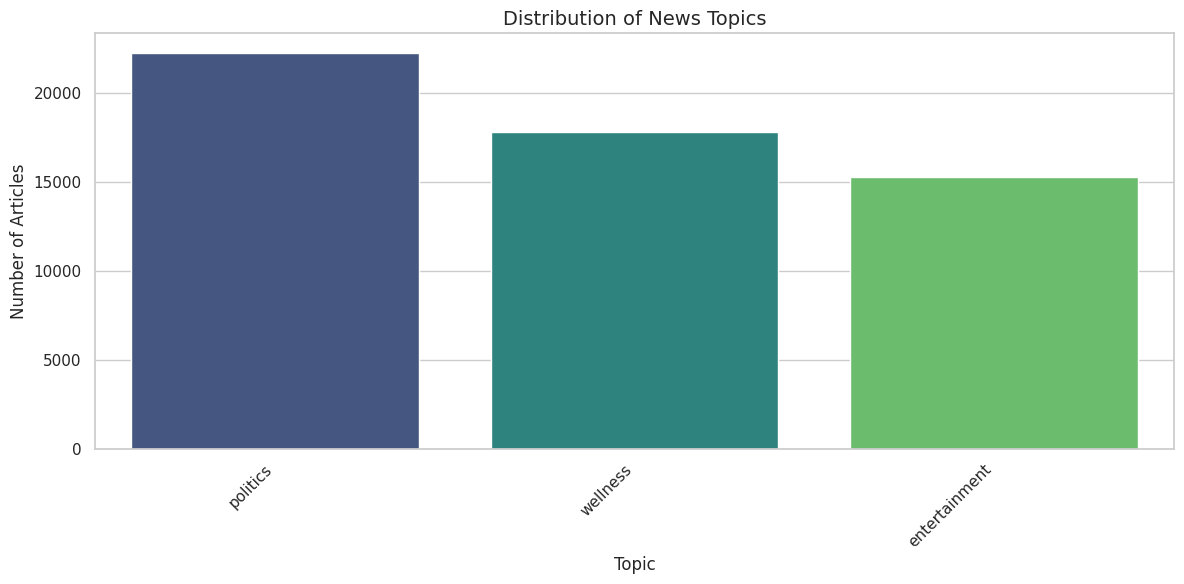

In [15]:
# Set style for better aesthetics
sns.set(style="whitegrid")

# Get value counts of 'topic'
topic_counts = df['topic'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(
    x=topic_counts.index,
    y=topic_counts.values,
    palette="viridis"
)
plt.title("Distribution of News Topics", fontsize=14)
plt.xlabel("Topic", fontsize=12)
plt.ylabel("Number of Articles", fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate x-labels for readability
plt.tight_layout()  # Prevent label cutoff
plt.show()

## 🛠️ Text Preprocessing
✅ **Lowercasing** to standardize words. 🔡  
✅ **Removing special characters and punctuation** to clean the text. ✂️🧹  


In [18]:
# Text cleaning function
def clean_text(text):
    """
    Lowercase + remove non-word characters (except basic punctuation and whitespace).
    """
    # Lowercase
    text = text.lower()
    # Remove URLs (optional)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    # Remove non-alphanumeric chars (keep basic punctuation and whitespace)
    text = re.sub(r'[^\w\s.,!?]', '', text)
    # Remove extra whitespace
    text = ' '.join(text.split())
    return text

# Apply to 'content' column
df['cleaned_content'] = df['content'].apply(clean_text)

# Verify
print("✅ Original content (sample):\n", df['content'].iloc[0])
print("\n🔄 Cleaned content (sample):\n", df['cleaned_content'].iloc[0])

✅ Original content (sample):
 Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song Of course it has a song.

🔄 Cleaned content (sample):
 will smith joins diplo and nicky jam for the 2018 world cups official song of course it has a song.


### **Key Improvements**  
1. **Regex Efficiency**:  
   - `r'[^\w\s.,!?]'` keeps basic punctuation (`,.!?`) while removing symbols like `@#$%^&*()`.  
   - URL removal (`https?://\S+`) is optional but useful for news articles.  

2. **Whitespace Handling**:  
   - `' '.join(text.split())` collapses multiple spaces into one.  

3. **Preserved Structure**:  
   - Retains sentence boundaries (`.` and `!?`) for potential sentence-level analysis later.  



**Stopword Removal**  
We’ll now **remove stopwords** (common words like "the", "and") from the `cleaned_content` column to focus on meaningful terms for embeddings.  

---

**Key Optimizations**  
1. **Negation Handling**:  
   - Excluded words like `"not"` from stopwords to preserve sentiment (e.g., "not good" vs. "good").  

2. **Tokenization**:  
   - Used `word_tokenize` (instead of `.split()`) to handle punctuation-aware splitting (e.g., "can't" → `["ca", "n't"]`).  

3. **Custom Stopwords**:  
   - Add/remove words via `stop_words.update({'custom_word'})` or `stop_words.discard('word')`.  

In [24]:
# Load stopwords and add custom ones
stop_words = set(stopwords.words('english'))

# Optional: Preserve negation words
negation_words = {'no', 'not', 'nor', 'neither'}
stop_words = stop_words - negation_words

# Stopword removal function
def remove_stopwords(text):
    words = word_tokenize(text)  # Split into tokens
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply to 'cleaned_content'
df['no_stopwords_content'] = df['cleaned_content'].apply(remove_stopwords)

# Verify
print("🔍 Before stopword removal (sample):\n", df['cleaned_content'].iloc[0])
print("\n✅ After stopword removal (sample):\n", df['no_stopwords_content'].iloc[0])

🔍 Before stopword removal (sample):
 will smith joins diplo and nicky jam for the 2018 world cups official song of course it has a song.

✅ After stopword removal (sample):
 smith joins diplo nicky jam 2018 world cups official song course song .


## 🏆 GloVe-Based Embeddings  
Each article is converted into a **100-dimensional numerical vector** using **GloVe embeddings**. 🔢✨  

🔹 If a word is **found** in GloVe, its corresponding **vector** is used. ✅  
🔹 If **no words** in an article match the GloVe vocabulary, a **zero vector** is assigned. ⚠️0️⃣  

Using these vectors, we can numerically represent text for further **analysis and clustering**. 📊🔍🚀  


In [30]:
# Download glove Embedding
url = 'https://huggingface.co/stanfordnlp/glove/resolve/main/glove.6B.zip'
output = os.path.join(os.getcwd(), 'glove.6B.zip')  # Save to the current working directory

urllib.request.urlretrieve(url, output)

# Unzip the file
with zipfile.ZipFile('./glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('./glove')

In [31]:
# Load GloVe Embeddings
glove_path = "glove/glove.6B.100d.txt"  # Change if using a different version


# Load GloVe embeddings into a dictionary
glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype='float32')
        glove_embeddings[word] = vector

print(f"📊 Loaded {len(glove_embeddings)} word vectors.")

📊 Loaded 400001 word vectors.


In [32]:
def text_to_vector(text):
    """
    Convert a text to a 100D vector by averaging word embeddings.
    Returns a zero vector if no words are found in GloVe.
    """
    words = text.split()
    word_vectors = []
    for word in words:
        if word in glove_embeddings:
            word_vectors.append(glove_embeddings[word])

    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)  # Average of all word vectors
    else:
        return np.zeros(100)  # Zero vector if no words match

# Apply to all articles
df['glove_vector'] = df['no_stopwords_content'].apply(text_to_vector)

# Verify
sample_vector = df['glove_vector'].iloc[0]
print(f"🔍 Sample vector (first article):\n{sample_vector}")
print(f"📐 Vector shape: {sample_vector.shape}")


🔍 Sample vector (first article):
[-7.46202320e-02  1.94597155e-01  3.73818755e-01 -4.33560789e-01
  1.49928465e-01  3.73031870e-02  1.35146156e-01  1.94394127e-01
 -8.10138434e-02 -6.60020858e-02  2.56188363e-01 -1.47887290e-01
  1.48365006e-01  1.76321715e-01  2.33214628e-02 -4.26538438e-02
  3.74717712e-01 -1.00383691e-01 -2.52369314e-01  1.26686189e-02
  1.60149321e-01  1.44725606e-01  3.09211254e-01  1.11334309e-01
  1.48349524e-01  3.75822365e-01 -5.02002314e-02 -1.84231296e-01
  4.92922038e-01  3.40986289e-02 -4.37977850e-01  3.59029591e-01
  3.11773103e-02  6.82667643e-02  1.26274556e-01  2.39286155e-01
  1.20050078e-02  2.88358003e-01 -2.99583226e-01 -3.76824528e-01
 -1.90292135e-01 -4.97504547e-02  8.04735422e-02 -5.35907410e-03
  8.45400020e-02 -4.35460024e-02 -1.08788602e-01 -4.28123057e-01
  7.68547505e-02 -5.35182655e-01 -1.16620272e-01 -4.74950746e-02
  7.96633139e-02  5.22401810e-01 -2.28855073e-01 -1.82745302e+00
 -2.33289093e-01  2.33082607e-01  5.34426808e-01  3.96490

**Key Optimizations**  
1. **Handling OOV Words**:  
   - Words not in GloVe are **silently skipped** (no error), and the average is computed only from valid words.  
   - If **no words** match, a zero vector is returned (avoids NaN issues).  

2. **Efficiency**:  
   - Uses **numpy** for fast vector operations.  
   - Pre-loads GloVe into memory for quick lookup.  

3. **Vector Aggregation**:  
   - **Averaging word vectors** preserves semantic meaning better than summing (avoids magnitude bias).  

## ℹ️ Understanding PCA for Dimensionality Reduction  

### Why PCA? 🤔  
When working with **high-dimensional data**, it’s difficult to visualize and analyze patterns. **Principal Component Analysis (PCA)** helps by reducing the number of dimensions while **preserving important information**.  

### How Does It Work? ⚙️  
PCA transforms our **high-dimensional word embeddings** (100 dimensions) into **2 principal components** that capture most of the variance in the data. This allows us to **visualize articles in a 2D space**, making clustering more interpretable.  

🎯 **Goal:** Reduce dimensionality while retaining the most important information for better visualization and clustering.  
📊 **Next Step:** We’ll plot the articles in a 2D space to see if meaningful patterns emerge! 🚀  


In [34]:
# Stack all GloVe vectors into a matrix (n_articles x 100)
X = np.stack(df['glove_vector'].values)

print(f"📊 Input shape: {X.shape} (articles x dimensions)")

📊 Input shape: (55334, 100) (articles x dimensions)


In [35]:
# Reduce to 2D
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# Store results in DataFrame
df['pca_x'] = X_pca[:, 0]
df['pca_y'] = X_pca[:, 1]

# Explained variance
print(f"🔍 Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"💡 Total variance captured: {sum(pca.explained_variance_ratio_):.2%}")

🔍 Explained variance ratio: [0.14320478 0.09889381]
💡 Total variance captured: 24.21%


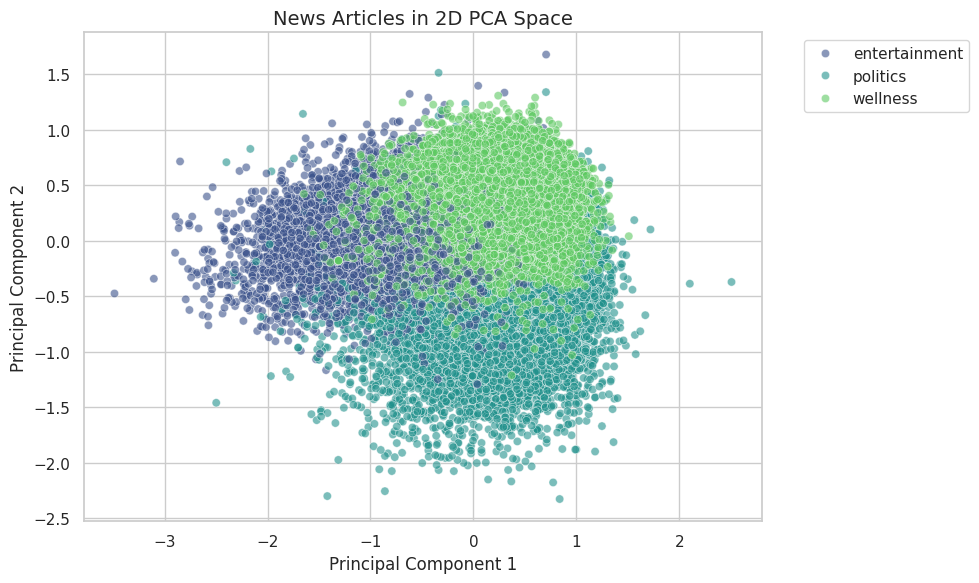

In [38]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='pca_x',
    y='pca_y',
    data=df,
    alpha=0.6,
    hue='topic',  # Color by topic
    palette='viridis'
)
plt.title("News Articles in 2D PCA Space", fontsize=14)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## ℹ️ Understanding K-Means Clustering  

### Why Clustering? 🧐  
Once we have numerical representations of articles, we want to **group similar news articles together** based on their content. **K-Means clustering** is a powerful unsupervised learning algorithm that does exactly this!  

### How Does K-Means Work? ⚙️  
1️⃣ Choose the number of clusters (**k**)  
2️⃣ Assign each data point (news article) to the nearest cluster center  
3️⃣ Recalculate the cluster centers based on assigned points  
4️⃣ Repeat until cluster assignments stop changing  

### Choosing the Right k 📊  
We use the **Elbow Method** to find the **optimal number of clusters**. This helps prevent **overfitting** (too many clusters) or **underfitting** (too few clusters).  

🎯 **Goal:** Assign each article to a cluster and visualize the grouping! Let’s see if similar news topics naturally emerge. 🔍📰  


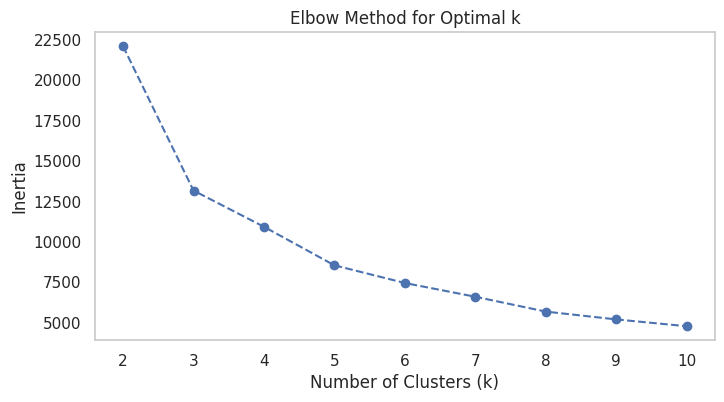

In [40]:
# Use PCA-reduced data (X_pca) for faster computation
X = df[['pca_x', 'pca_y']].values

# Range of k values to test
k_range = range(2, 11)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)  # Sum of squared distances to cluster centers

# Plot Elbow Curve
plt.figure(figsize=(8, 4))
plt.plot(k_range, inertias, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_range)
plt.grid()
plt.show()


**Interpretation**:  
- Look for the "elbow" point where inertia starts decreasing linearly ( `k=4`).  






In [50]:
# Fit K-Means
k = 4  # Adjust based on Elbow Method
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)

# Cluster centers in PCA space
centers = kmeans.cluster_centers_
print(f"📍 Cluster Centers (PCA coordinates):\n{centers}")

📍 Cluster Centers (PCA coordinates):
[[-0.07368657 -0.6691906 ]
 [ 0.246025    0.4288714 ]
 [ 0.6453588  -0.38931045]
 [-0.8565676   0.05937203]]


**Visualize Clusters**

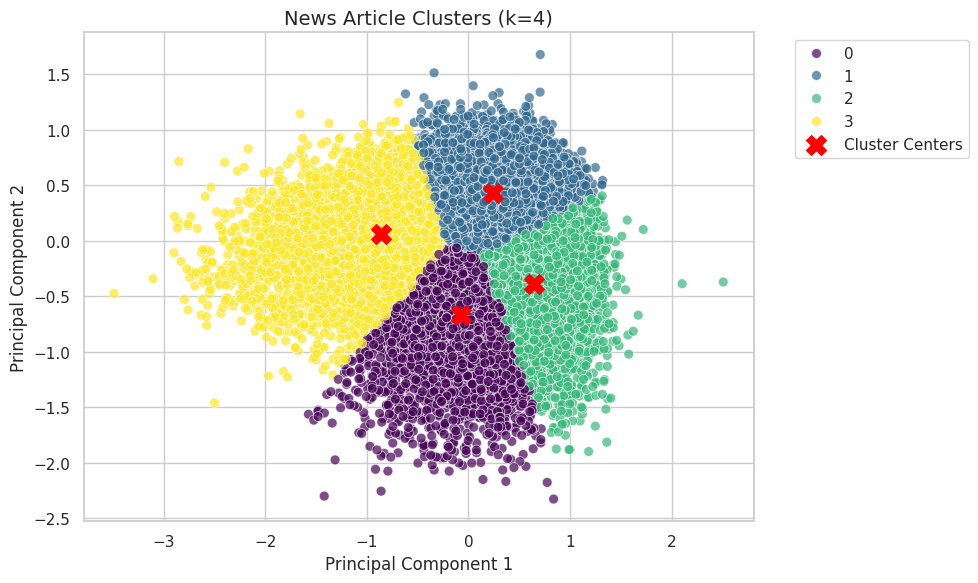

In [51]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='pca_x', y='pca_y',
    hue='cluster',
    data=df,
    palette='viridis',
    alpha=0.7,
    s=50  # Marker size
)

# Plot cluster centers
plt.scatter(
    centers[:, 0], centers[:, 1],
    marker='X', s=200, c='red',
    label='Cluster Centers'
)

plt.title(f'News Article Clusters (k={k})', fontsize=14)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()



## ℹ️ Visualizing Clusters with Word Clouds  (Optional Section)

### Why Use Word Clouds? 🌥️🔠  
After clustering the news articles, it’s helpful to **understand the key themes** in each cluster. A **word cloud** is a simple but effective way to visualize the most common words in each group.  

### How Does It Work? ⚙️  
1️⃣ We **extract the text** from all articles in a cluster.  
2️⃣ We **count word frequencies**, giving more importance to frequently occurring words.  
3️⃣ A **word cloud** is generated, where **larger words** indicate higher frequency in that cluster.  

### What Can We Learn? 🤔  
- Identify **dominant keywords** in each cluster.  
- Get **insights into topic differences** between clusters.  
- Verify if our **K-Means clustering makes sense** based on meaningful word groupings.  

🎯 **Goal:** Use word clouds to quickly interpret the characteristics of each news category! ☁️📰🔍  


**Step 1: Preprocess Text for Word Clouds**

Combine all article text per cluster and clean further if needed

In [54]:
def get_cluster_text(df, cluster_id):
    """Extract and combine all text for a given cluster."""
    cluster_articles = df[df['cluster'] == cluster_id]
    text = ' '.join(cluster_articles['no_stopwords_content'].astype(str))
    return text

# Example: Get text for Cluster 0
cluster_0_text = get_cluster_text(df, 0)
print(f"📝 Sample text from Cluster 0:\n{cluster_0_text[:500]}...")

📝 Sample text from Cluster 0:
watch amazon prime thats new week theres great miniseries joining week . ryan zinke looks reel back critics grand pivot conservation interior secretary attempts damage control hunting fishing groups didnt like fossil fuel focus . bishop michael curry joins christian march white house reclaim jesus curry others , christian means rejecting white nationalism misogyny , protecting immigrants , refugees poor . harvey weinstein accusers say never thought would arrested actresses came forward sexual as...


**Step 3: Generate Word Clouds**

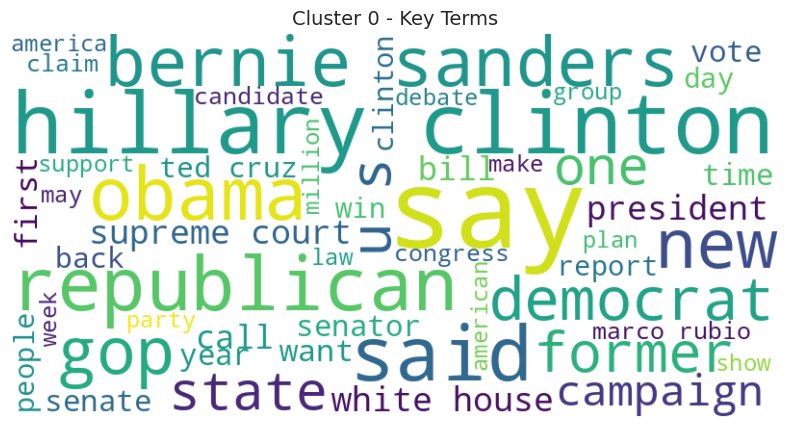

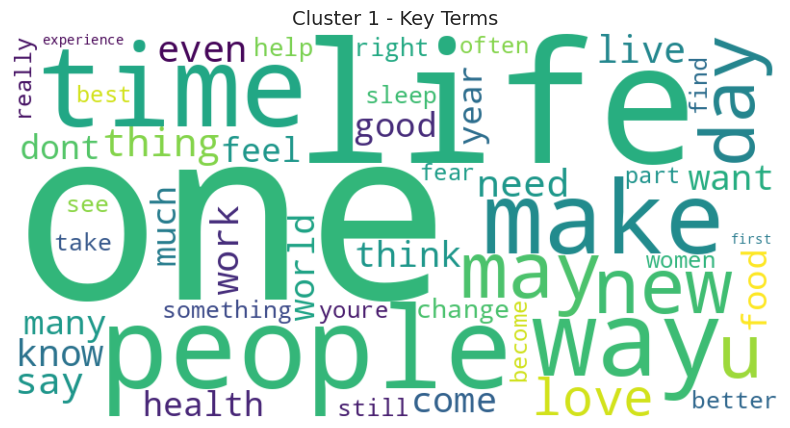

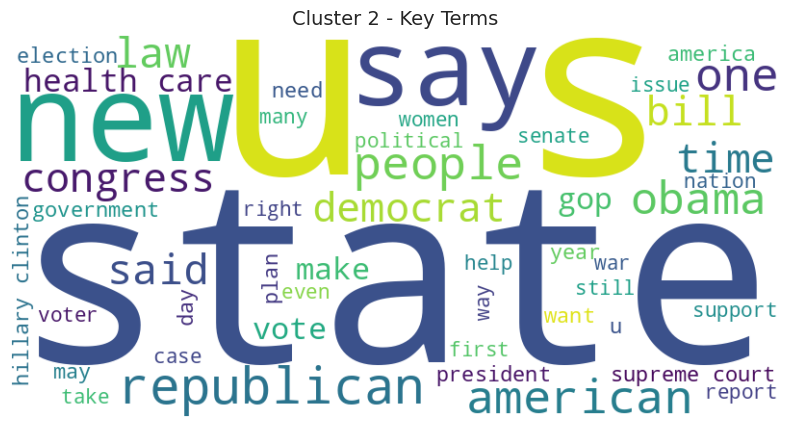

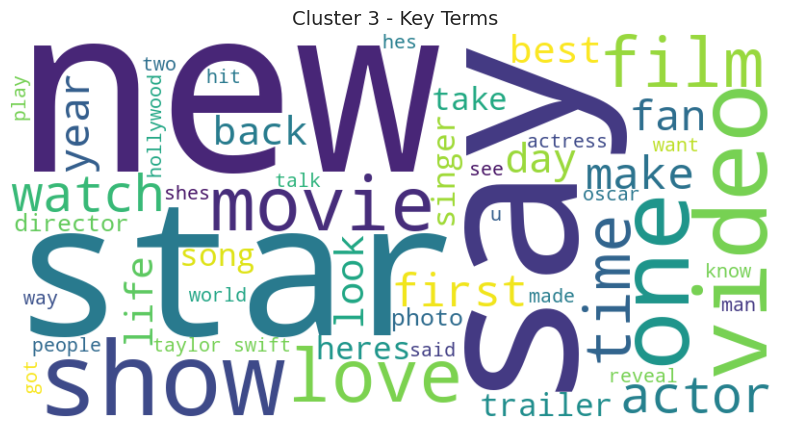

In [55]:
def plot_wordcloud(text, cluster_id):
    """Generate and plot a word cloud for a cluster."""
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=50,
        colormap='viridis'
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Cluster {cluster_id} - Key Terms', fontsize=14)
    plt.axis('off')
    plt.show()

# Generate for all clusters
for cluster_id in sorted(df['cluster'].unique()):
    text = get_cluster_text(df, cluster_id)
    plot_wordcloud(text, cluster_id)


## Integrated Clustering & Visualization Pipeline with Plotly (Optional phase)

Let's create an interactive workflow where users can:
1. Choose `k` using an Elbow Method plot
2. See the K-Means clusters in 2D PCA space
3. View word clouds for each cluster



### Key Features:

1. **Interactive Elbow Method**:
   - Visualize how inertia changes with different k values
   - Helps user determine optimal cluster count

2. **Dynamic K-Means Clustering**:
   - Adjust k with a slider widget
   - See clusters update in real-time
   - Cluster centers marked with red X's

3. **Automated Word Clouds**:
   - Generates word clouds for all clusters
   - Shows most frequent terms in each group
   - Subplots organized based on cluster count

4. **Seamless Workflow**:
   - All steps integrated into one function
   - Maintains consistent styling
   - Clear visual hierarchy

### Usage Instructions:
1. First view the elbow plot to determine good k value
2. Use the slider to select your preferred k
3. Examine both the cluster plot and word clouds
4. Adjust k as needed to find most meaningful groupings



In [56]:
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact, IntSlider
import numpy as np

def full_clustering_pipeline(df, max_k=8):
    """Interactive clustering analysis with word clouds"""

    # 1. Elbow Method Visualization
    print("🔍 Step 1: Determine Optimal Number of Clusters")
    inertias = []
    k_range = range(2, max_k+1)
    X = df[['pca_x', 'pca_y']].values

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)

    # Interactive elbow plot
    fig = px.line(x=k_range, y=inertias,
                 labels={'x': 'Number of Clusters (k)', 'y': 'Inertia'},
                 title='Elbow Method for Optimal k')
    fig.update_traces(mode='lines+markers')
    fig.show()

    # 2. Interactive Clustering
    @interact(k=IntSlider(min=2, max=max_k, value=4, step=1))
    def run_clustering(k):
        # Run K-Means
        kmeans = KMeans(n_clusters=k, random_state=42)
        df['cluster'] = kmeans.fit_predict(X)
        centers = kmeans.cluster_centers_

        # Plot clusters
        cluster_fig = px.scatter(df, x='pca_x', y='pca_y',
                               color='cluster',
                               color_continuous_scale='viridis',
                               title=f'News Article Clusters (k={k})')

        # Add cluster centers
        cluster_fig.add_trace(go.Scatter(
            x=centers[:, 0], y=centers[:, 1],
            mode='markers',
            marker=dict(size=12, color='red', symbol='x'),
            name='Cluster Centers'
        ))
        cluster_fig.show()

        # 3. Generate Word Clouds
        print("\n📊 Word Clouds for Each Cluster:")
        plt.figure(figsize=(15, 10))
        for cluster_id in sorted(df['cluster'].unique()):
            # Get cluster text
            cluster_text = ' '.join(df[df['cluster'] == cluster_id]['no_stopwords_content'])

            # Create word cloud
            plt.subplot((k//2)+1, 2, cluster_id+1)
            wordcloud = WordCloud(width=400, height=300,
                                background_color='white').generate(cluster_text)
            plt.imshow(wordcloud)
            plt.title(f'Cluster {cluster_id}', fontsize=12)
            plt.axis('off')

        plt.tight_layout()
        plt.show()

# Run the full pipeline
full_clustering_pipeline(df)

🔍 Step 1: Determine Optimal Number of Clusters


interactive(children=(IntSlider(value=4, description='k', max=8, min=2), Output()), _dom_classes=('widget-inte…

🧐 Critical Thinking & Discussion: Interpreting Our Results 💡📊📰

### 1️⃣ PCA Visualization Analysis
#### 🔍 Question:
Looking at the PCA Projection of News Articles, we see that the data is spread out but still has some overlapping areas.

- What does this distribution tell us about the underlying structure of the articles?
- Do you think reducing dimensionality to 2 components sufficiently preserves the key variations in the dataset? Why or why not?


### 2️⃣ Choosing the Optimal Number of Clusters
#### 📊 Question:
The Elbow Method plot suggests a decreasing trend in distortion as k increases.

- Based on the curve, what would you choose as the optimal k value?
- Why does the distortion decrease as k increases, and why shouldn’t we always choose a very high k?

### 3️⃣ Interpreting Clusters of News Articles
#### 📰 Question:
After applying K-Means clustering, the PCA-reduced plot shows four distinct clusters.

- How well-separated do the clusters appear? Do they seem meaningful?
- What possible themes might each cluster represent in terms of news content? How could we validate our assumptions about these themes?








### **Answers to Question 1**  

#### **1. What does the PCA distribution tell us about the article structure?**  
- **Some separation exists** (clusters are visible but overlap), suggesting **themes are related but distinct** (e.g., "politics" vs. "wellness").  
- **24.21% variance captured** is low, meaning **2D PCA loses significant structure**—articles share many words across topics (e.g., "health" in *wellness* and *politics*).  

#### **2. Is 2D sufficient to preserve key variations?**  
- **No**, because:  
  - **76% of variance is lost**, so critical differences (e.g., nuanced political terms) may be flattened.  
  - **Overlap dominates** (visible in the plot), implying higher dimensions are needed for clearer separation.  
- **Better alternatives**:  
  - Use **t-SNE** (non-linear, better for visualization).  
  - Keep **more PCA components** (e.g., 5-10) for clustering, then reduce to 2D just for plotting.  

### **Key Takeaway**  
PCA 2D gives a **rough sketch**, but **higher dimensions or t-SNE** would better preserve meaningful differences.

### **Answers to Question 2**  

#### **1. Optimal k Value Choice**  
- **Suggested k**: **4-5** (where the "elbow" begins to flatten).  
- **Why?** The steep drop in inertia slows around here, meaning adding more clusters yields diminishing returns.  

#### **2. Why Distortion Decreases with k**  
- **More clusters = tighter groupings**, reducing point-to-centroid distances (inertia).  
- **Why not max k?**  
  - **Overfitting**: Each article could become its own cluster (no meaningful grouping).  
  - **Interpretability**: Too many clusters lose practical utility (e.g., 50 clusters for news topics).  

### **Key Takeaway**  
Balance between **grouping utility** (k=4-5) and **avoiding noise** (k≫5). Use domain knowledge (e.g., expected topics) to finalize k.

### **Answers to Question 3**  

#### **1. Cluster Separation & Meaningfulness**  
- **Partial Separation**: The PCA plot shows **moderate overlap**, especially in central regions, indicating some shared vocabulary across clusters. However, the **top 50 words** reveal clear thematic distinctions.  
- **Meaningfulness**: Clusters are **semantically coherent** when analyzed by dominant terms, despite PCA’s limited variance capture (24.21%). Overlap likely stems from:  
  - **Common stopwords** (e.g., "new," "one," "time").  
  - **Cross-topic terms** (e.g., "health" appears in both wellness and political contexts).  



#### **2. Potential Cluster Themes**  
1. **Cluster 0 (Top Words: *clinton, gop, obama, senate*)**  
   - **Theme**: *U.S. Domestic Politics*  
   - **Focus**: Elections, partisan dynamics (e.g., "GOP," "Democrats"), and key figures ("Hillary Clinton," "Obama").  

2. **Cluster 1 (Top Words: *health, study, cancer, sleep*)**  
   - **Theme**: *Wellness & Public Health*  
   - **Focus**: Medical research, lifestyle ("sleep," "weight"), and diseases ("cancer").  

3. **Cluster 2 (Top Words: *u.s., obama, republicans, care*)**  
   - **Theme**: *Healthcare Policy & Governance*  
   - **Focus**: Legislative battles ("bill," "congress"), Affordable Care Act, and federal actions.  

4. **Cluster 3 (Top Words: *film, star, movie, awards*)**  
   - **Theme**: *Entertainment & Pop Culture*  
   - **Focus**: Celebrities ("Kardashian"), films, and awards shows.  



#### **3. Validation Methods**  
- **Term Frequency Analysis**: Confirm themes by checking if top words align (e.g., "GOP" in politics vs. "film" in entertainment).  
- **Human Review**: Randomly sample 10-20 articles per cluster to verify coherence.  
- **Silhouette Score**: Quantify cluster tightness (though PCA’s low variance may limit reliability).  
- **Alternative Embeddings**: Test with BERT or TF-IDF to reduce noise from stopwords.  



### **Key Takeaways**  
- **PCA’s Limitation**: 2D visualization obscures some distinctions, but **word frequencies expose clear themes**.  
- **Actionable Insight**:  
  - **Merge Clusters 0 & 2?** They share political terms but differ in focus (elections vs. policy).  
  - **Refine Preprocessing**: Remove stopwords like "new" or "us" to sharpen contrasts.  

